In [35]:
import torch
import torch.nn.functional as F
import numpy as np
import PIL.Image as pim
%matplotlib inline

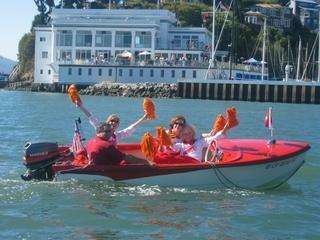

In [500]:
image = pim.open('images/0002136.jpg')
image

In [501]:
image_tensor = torch.Tensor([np.array(image).transpose((2,0,1))])

In [471]:
image_tensor.shape

torch.Size([1, 3, 240, 320])

In [39]:
radius = 3

In [339]:
lcn_filter = torch.nn.Conv2d(1,1,radius)

In [182]:
temp_params = lcn_filter.parameters()
weight = next(temp_params)
bias = next(temp_params)

In [183]:
weight,bias

(Parameter containing:
 tensor(1.00000e-02 *
        [[[[ 9.9383, -5.3846, -5.9510,  0.4488,  5.0518, -0.1100, -7.8386,
             4.4133,  1.9993,  6.1942],
           [-5.2314,  7.1576, -7.7150, -5.1589, -4.8809,  5.1743, -4.9279,
            -8.8827, -4.5817,  6.9388],
           [ 8.3372,  2.7165,  4.0247,  1.5746,  4.9316, -0.3425, -8.1843,
            -7.1236, -2.0820, -4.3238],
           [ 1.5982, -4.5097,  2.6175, -5.8379,  8.3546, -6.4791, -6.4755,
            -4.2067, -9.2203, -2.6728],
           [ 8.7766,  1.7923, -9.6405, -6.7919, -9.3036, -5.8690,  8.1236,
            -9.4658, -9.6844,  0.3570],
           [-7.5066, -4.2842,  0.6021, -6.9239, -9.9902, -6.4597,  0.7302,
            -6.1567,  4.6794,  0.8124],
           [-6.1865,  1.6772,  6.1506,  7.2766,  7.7067,  9.5572, -6.9393,
            -3.3470,  4.8346, -6.4144],
           [-6.0870,  1.9999, -7.4837, -9.9351,  5.4879,  2.1926, -2.0090,
            -0.2923, -1.4953, -5.3273],
           [-0.9214, -3.2475,  2.08

In [347]:
new_weights = torch.nn.Parameter(torch.Tensor([[np.ones((radius,radius))/radius**2]]))
new_bias = torch.nn.Parameter(torch.Tensor([0]))

In [348]:
lcn_filter.register_parameter('weight',new_weights)
lcn_filter.register_parameter('bias',new_bias)

In [170]:
dummy = torch.rand((1,1,240,320))

In [171]:
dummy.shape

torch.Size([1, 1, 240, 320])

In [172]:
dummy

tensor([[[[ 0.1598,  0.9510,  0.3749,  ...,  0.8942,  0.9823,  0.2338],
          [ 0.4764,  0.1521,  0.6952,  ...,  0.1744,  0.7842,  0.5203],
          [ 0.3720,  0.3195,  0.9364,  ...,  0.0706,  0.7623,  0.2014],
          ...,
          [ 0.1077,  0.8231,  0.2291,  ...,  0.4836,  0.8844,  0.5424],
          [ 0.1840,  0.9601,  0.2992,  ...,  0.8736,  0.7582,  0.6384],
          [ 0.1981,  0.8222,  0.4341,  ...,  0.5436,  0.6283,  0.2791]]]])

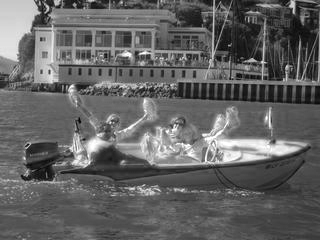

In [502]:
pim.fromarray((image_tensor[0,0]).byte().numpy())

In [503]:
pim.fromarray((lcn_filter(image_tensor)[0,0]).byte().numpy())

NameError: name 'lcn_filter' is not defined

In [356]:
image_tensor.shape

torch.Size([1, 1, 240, 320])

In [358]:
F.pad(image_tensor,(0, 0, 5 // 2, (5 - 1) // 2)).shape

torch.Size([1, 1, 244, 320])

In [260]:
def gaussian_filter(kernel_shape):
    x = np.zeros(kernel_shape, dtype='float32')
 
    def gauss(x, y, sigma=2.0):
        Z = 2 * np.pi * sigma ** 2
        return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))
 
    mid = np.floor(kernel_shape[-1] / 2.)
    for kernel_idx in range(0, kernel_shape[1]):
        for i in range(0, kernel_shape[2]):
            for j in range(0, kernel_shape[3]):
                x[0, kernel_idx, i, j] = gauss(i - mid, j - mid)
 
    return x / np.sum(x)

In [442]:
gfilter = torch.Tensor(gaussian_filter((1,3,9,9)))

In [504]:
filtered = F.conv2d(image_tensor,gfilter,padding=8) ## padding = 8 = 9-1 (radius - 1 ) for border == 'full'

In [505]:
filtered.byte().numpy()[0][0].shape

(248, 328)

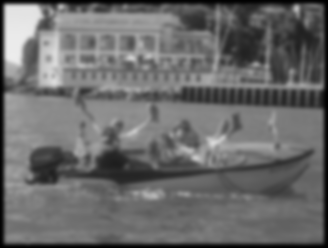

In [506]:
pim.fromarray(filtered.byte().numpy()[0][0])

In [507]:
filtered[:,:,mid:-mid,mid:-mid].shape

torch.Size([1, 1, 240, 320])

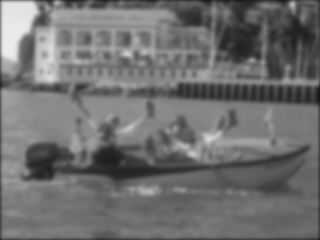

In [508]:
pim.fromarray(filtered[:,:,mid:-mid,mid:-mid].byte().numpy()[0][0])

In [509]:
mid = int(np.floor(gfilter.shape[2] / 2.))

image_tensor - torch.Tensor(np.broadcast(filtered[:,:,mid:-mid,mid:-mid],1))

In [510]:
l = np.broadcast(filtered[:,:,mid:-mid,mid:-mid],1)

In [511]:
p = np.ndarray((240,320))

In [512]:
p.flat = [u for u,v in l]

In [513]:
image_tensor.numpy().shape

(1, 3, 240, 320)

In [514]:
np.array([p]).shape

(1, 240, 320)

In [515]:
(image_tensor[0][0] - torch.Tensor(p)).mean()

tensor(-13.1737)

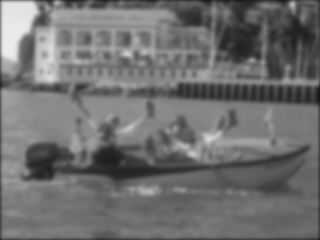

In [516]:
pim.fromarray(p.astype('uint8'))

In [517]:
centered_image = torch.Tensor([(image_tensor.numpy()[0] - np.array([p]))])

In [518]:
centered_image[0].mean()  ##  mean is near 0 (Why not exact 0??)

tensor(1.2893)

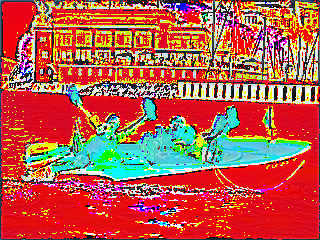

In [519]:
pim.fromarray(centered_image.byte().numpy()[0].transpose((1,2,0)))

In [520]:
sum_sqr_XX = F.conv2d(centered_image.pow(2),gfilter,padding=8)

In [521]:
denom = sum_sqr_XX[:,:,mid:-mid,mid:-mid].sqrt()

In [522]:
denom.shape

torch.Size([1, 1, 240, 320])

In [523]:
per_img_mean = denom.mean()

In [524]:
per_img_mean

tensor(27.0697)

In [525]:
divisor = np.maximum(per_img_mean.numpy(),denom.numpy())

In [526]:
divisor = np.maximum(divisor, 1e-4)

In [527]:
new_image = centered_image / torch.Tensor(divisor)

In [528]:
pim.fromarray(new_image.byte().numpy()[0].transpose((1,2,0))).save('boat_LCN.png')

In [529]:
pim.fromarray(image_tensor.byte().numpy()[0].transpose((1,2,0))).save('boat.png')